# Rendering

## Table of Contents

1. [Introduction](#1--introduction)
2. [Basic Rendering Primitives](#2--basic-rendering-primitives)
    - [Rendering a Point](#2.1--rendering-a-point)
    - [Rendering a Line](#2.2--rendering-a-line)
    - [Rendering a Triangle](#2.3--rendering-a-triangle)
3. [Transformation Matrices](#3--transformation-matrices)
    - [Translation Matrix](#3.1--translation-matrix)
    - [Rotation Matrix](#3.2--rotation-matrix)
    - [Scaling Matrix](#3.3--scaling-matrix)
4. [Rasterization Algorithm](#4--rasterization-algorithm)
5. [Shading Techniques](#5--shading-techniques)
    - [Flat Shading](#5.1--flat-shading)
    - [Gouraud Shading](#5.2--gouraud-shading)

## 1- Introduction

So far, we have explored various methods to **process**, **segment**, and **classify** images. Now, it's time to take the next step and create our own images!

In this notebook, we will dive into some fundamental rendering techniques and uncover the fascinating process behind how computers generate visuals.

It's been a while since I last worked on something similar (back when I explored the OpenGL C++ library), so this feels like a refreshing revisit. - Safae

---

In [2]:
import numpy as np
from OpenGL.GL import *
from OpenGL.GLU import *
import pygame
from pygame.locals import *
from PIL import Image
from IPython.display import display, Image as IPyImage
import io

pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


### OpenGL Rendering Setup in Jupyter Notebooks

Before we start rendering geometric primitives with OpenGL, it's important to understand the infrastructure we've set up to make OpenGL work within a Jupyter notebook environment.

**1. `init_pygame(width=400, height=400)`**

This function creates the foundation for our rendering pipeline by:
- Initializing the Pygame library which provides a window for OpenGL rendering
- Setting up an OpenGL rendering context with double buffering
- Configuring the viewport with a white background
- Setting up a perspective projection with a 45-degree field of view
- Positioning our camera 5 units away from the origin along the z-axis

**2. `render_to_image(width=400, height=400)`**

This function acts as a bridge between OpenGL and Jupyter by:
- Capturing the current state of the OpenGL framebuffer after rendering
- Reading the raw RGBA pixel data from the GPU memory
- Converting this data into a PIL Image object
- Adjusting for OpenGL's coordinate system by flipping the image vertically
- Returning an image that can be displayed in the notebook

**3. `display_gl_scene(render_shape, width=400, height=400, **shape_args)`**

This orchestrator function ties everything together by:
- Setting up the rendering environment with `init_pygame`
- Executing the provided rendering function (e.g., for points, lines, triangles)
- Swapping buffers to make the rendered content visible
- Converting the rendered scene to an image with `render_to_image`
- Creating a byte stream to save the image in PNG format
- Displaying the image in the Jupyter notebook
- Cleaning up resources by closing the Pygame window

These three functions create a complete pipeline that allows us to use OpenGL's powerful rendering capabilities within the Jupyter notebook environment, where we can visualize our graphics programming experiments directly alongside our code and explanations.

In [3]:
# OpenGL is native to a C++ environment, so we need to adapt it for jupyter notebook usage
def init_pygame(width=200, height=150):
    """Initialize a Pygame window for OpenGL rendering."""
    pygame.init()
    pygame.display.set_mode((width, height), DOUBLEBUF | OPENGL)
    glClearColor(1.0, 1.0, 1.0, 1.0)
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    gluPerspective(45, (width/height), 0.1, 50.0)
    glTranslatef(0.0, 0.0, -5)

# helper function to render any scene we obtain so it can be shown as an output
def render_to_image(width=400, height=400):
    """Render the current OpenGL scene to a PIL Image."""
    # Read the pixels from the framebuffer
    glReadBuffer(GL_FRONT)
    pixels = glReadPixels(0, 0, width, height, GL_RGBA, GL_UNSIGNED_BYTE)
    
    # Convert to a PIL Image
    image = Image.frombuffer("RGBA", (width, height), pixels, "raw", "RGBA", 0, 1)
    image = image.transpose(Image.FLIP_TOP_BOTTOM)  # OpenGL has inverted y-axis
    
    return image

# main function for complete display
def display_gl_scene(render_shape, width=400, height=400, **shape_args):
    """Initialize OpenGL, render something, and display it."""
    init_pygame(width, height)
    render_shape(**shape_args)
    pygame.display.flip()
    image = render_to_image(width, height)
    
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        display(IPyImage(output.getvalue()))
    
    pygame.quit()

## 2- Basic Rendering Primitives

### 2.1- Rendering a Point

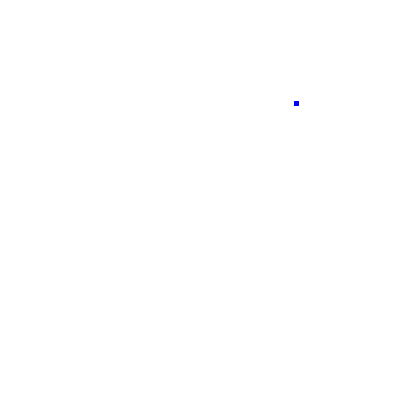

In [4]:
def render_point(v, color, size, n_points=1):
    for i in range(n_points):
        glPointSize(size[i])
        glBegin(GL_POINTS)
        r, g, b = color[i]
        glColor3f(r, g, b)
        x, y, z = v[i]
        glVertex3f(x, y, z)
        glEnd()
    
v = [(1, 1, 0)]
color = [(0, 0, 1)]
size = [5]

display_gl_scene(render_point, v=v, color=color, size=size)

### 2.1- Rendering a Line

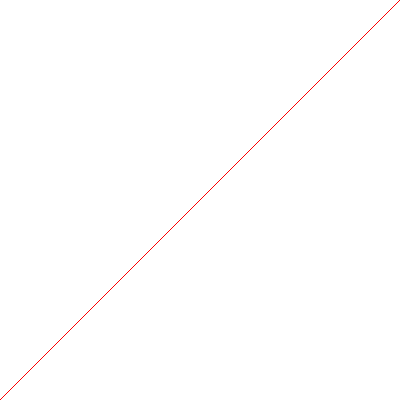

In [5]:
def render_line(v1, v2, color, n_lines=1):
    glBegin(GL_LINES)
    for i in range(n_lines):
        r, g, b = color[i]
        glColor3f(r, g, b)
        x1, y1, z1 = v1[i]
        x2, y2, z2 = v2[i]
        glVertex3f(x1, y1, z1)
        glVertex3f(x2, y2, z2)
    glEnd()
    
v1 = [(-3, -3, 0)]
v2 = [(3, 3, 0)]
color = [(1, 0, 0)]

display_gl_scene(render_line, v1=v1, v2=v2, color=color)

### 2.1- Rendering a Triangle

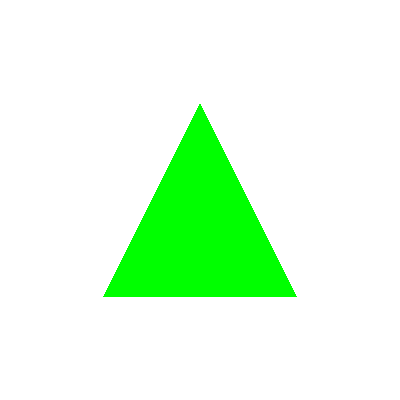

In [6]:
def render_triangle(v1, v2, v3, color, n_triangles=1):
    glBegin(GL_TRIANGLES)
    for i in range(n_triangles):
        r, g, b = color[i]
        glColor3f(r, g, b)
        x1, y1, z1 = v1[i]
        x2, y2, z2 = v2[i]
        x3, y3, z3 = v3[i]
        glVertex3f(x1, y1, z1)
        glVertex3f(x2, y2, z2)
        glVertex3f(x3, y3, z3)
    glEnd()
    
v1 = [(-1, -1, 0)]
v2 = [(1, -1, 0)]
v3 = [(0, 1, 0)]
    
color = [(0, 1, 0)]

display_gl_scene(render_triangle, v1=v1, v2=v2, v3=v3, color=color)

## 3- Transformation Matrices

### 3.1- Translation Matrix

In [7]:
def translate(v, dv):
    return [v[i] + dv[i] for i in range(len(v))]

#### 3.1.1- Point Translation

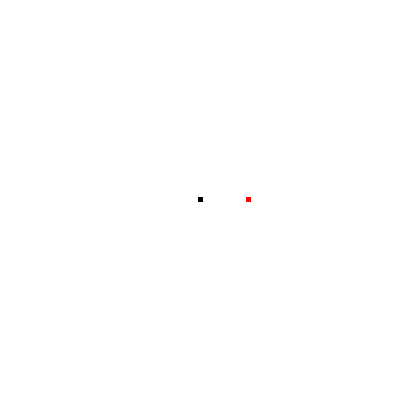

In [8]:
v = (0, 0, 0)
dv = (0.5, 0, 0)

translated_v = translate(v, dv)

v_list = [v, translated_v]

original_color = (0, 0 , 0)
translated_color = (1, 0, 0)
colors = [original_color, translated_color]
sizes = [5, 5]

display_gl_scene(render_point,v=v_list, color=colors, size=sizes, n_points=2)

#### 3.1.2- Line Translation

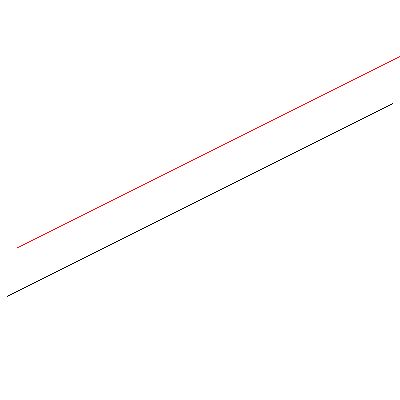

In [9]:
v1 = [(-2, -1, 0)]
v2 = [(2, 1, 0)]
dv = (0.1, 0.5, 0)

v1.append(translate(v1[0], dv))
v2.append(translate(v2[0], dv))

original_color = (0, 0, 0)
translated_color = (1, 0, 0)
colors = [original_color, translated_color]

display_gl_scene(render_line, v1=v1, v2=v2, color=colors, n_lines=2)

#### 3.1.3- Triangle Translation

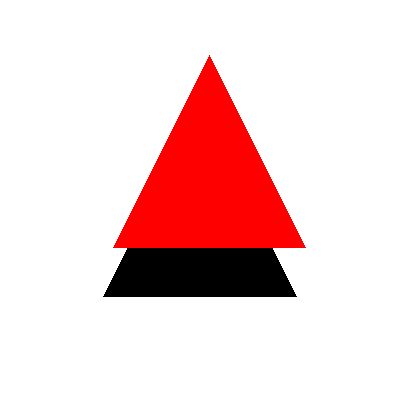

In [10]:
v1 = [(-1, -1, 0)]
v2 = [(1, -1, 0)]
v3 = [(0, 1, 0)]

dv = (0.1, 0.5, 0)

v1.append(translate(v1[0], dv))
v2.append(translate(v2[0], dv))
v3.append(translate(v3[0], dv))

original_color = (0, 0, 0)
translated_color = (1, 0, 0)
colors = [original_color, translated_color]

display_gl_scene(render_triangle, v1=v1, v2=v2, v3=v3, color=colors, n_triangles=2)

For all three primitives, **translation** fundamentally boils down to shifting their main components.

By adding a translation vector to their respective coordinates, the transformation seamlessly integrates into the rendering process.

### 3.2- Rotation Matrix

In [11]:
def rotate(v, theta, axis='z'):
    theta = np.radians(theta)  
    if axis == 'z':
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                     [np.sin(theta), np.cos(theta), 0],
                                     [0, 0, 1]])
    elif axis == 'y':
        rotation_matrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                                     [0, 1, 0],
                                     [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'x':
        rotation_matrix = np.array([[1, 0, 0],
                                     [0, np.cos(theta), -np.sin(theta)],
                                     [0, np.sin(theta), np.cos(theta)]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    point = np.array(v)
    rotated_point = np.dot(rotation_matrix, point)
    return rotated_point.tolist()

#### 3.2.1- Point Rotation

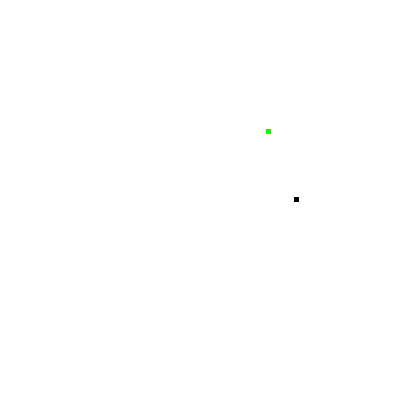

In [12]:
v = (1, 0, 0)
theta = 45
rotate_v = rotate(v, theta)

v_list = [v, rotate_v]

original_color = (0, 0 , 0)
rotate_color = (0, 1, 0)
colors = [original_color, rotate_color]
sizes = [5, 5]

display_gl_scene(render_point,v=v_list, color=colors, size=sizes, n_points=2)

#### 3.2.2- Line Rotation

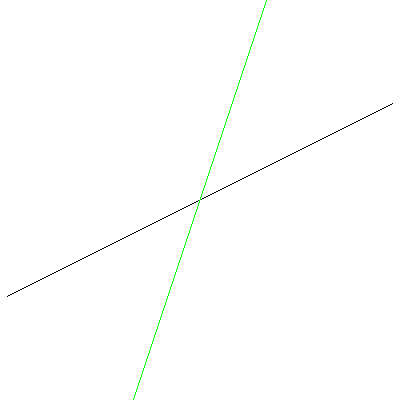

In [13]:
v1 = [(-2, -1, 0)]
v2 = [(2, 1, 0)]
theta = 45

v1.append(rotate(v1[0], theta))
v2.append(rotate(v2[0], theta))

original_color = (0, 0, 0)
colors = [original_color, rotate_color]

display_gl_scene(render_line, v1=v1, v2=v2, color=colors, n_lines=2)

#### 3.2.3- Triangle Rotation

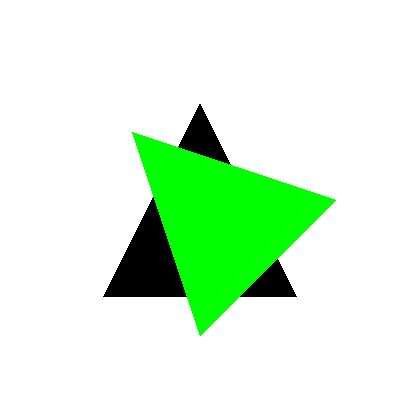

In [14]:
v1 = [(-1, -1, 0)]
v2 = [(1, -1, 0)]
v3 = [(0, 1, 0)]

theta = 45

v1.append(rotate(v1[0], theta))
v2.append(rotate(v2[0], theta))
v3.append(rotate(v3[0], theta))

original_color = (0, 0, 0)
colors = [original_color, rotate_color]

display_gl_scene(render_triangle, v1=v1, v2=v2, v3=v3, color=colors, n_triangles=2)

Once again, much like the **translation** operation, **rotation** is also just a matter of shifting the main components of the primitives.

### 3.3- Scaling Matrix

In [15]:
def scale(v, sv):
    scaled = np.array(v)*sv
    return scaled.tolist()

#### 3.3.1- Point Scale

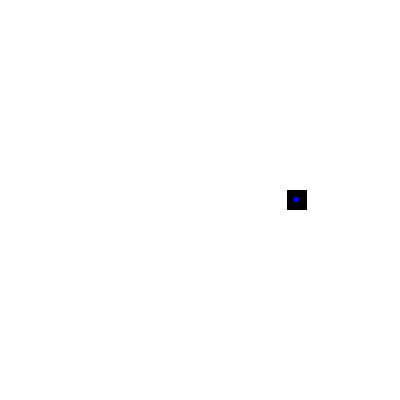

In [16]:
# Can't use point scale for this one, as it will simply send the point elsewhere
v = (1, 0, 0)
v_list = [v, v]

original_color = (0, 0 , 0)
scale_color = (0, 0, 1)
colors = [original_color, scale_color]
sizes = [20, 5] # we can just modify the size though

display_gl_scene(render_point,v=v_list, color=colors, size=sizes, n_points=2)

#### 3.3.2- Line Scale

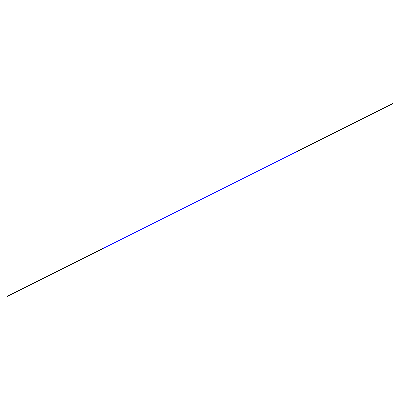

In [17]:
v1 = [(-2, -1, 0)]
v2 = [(2, 1, 0)]
s = 0.5

v1.append(scale(v1[0], s))
v2.append(scale(v2[0], s))

original_color = (0, 0, 0)
colors = [original_color, scale_color]

display_gl_scene(render_line, v1=v1, v2=v2, color=colors, n_lines=2)

#### 3.3.3- Triangle Scale

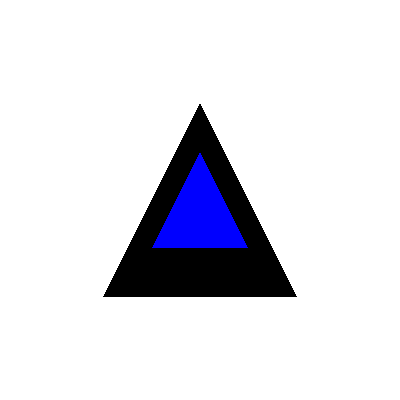

In [18]:
v1 = [(-1, -1, 0)]
v2 = [(1, -1, 0)]
v3 = [(0, 1, 0)]

s = 0.5

v1.append(scale(v1[0], s))
v2.append(scale(v2[0], s))
v3.append(scale(v3[0], s))

original_color = (0, 0, 0)
colors = [original_color, scale_color]

display_gl_scene(render_triangle, v1=v1, v2=v2, v3=v3, color=colors, n_triangles=2)

Scaling behaves differently compared to translation and rotation. For primitives with more than one dimension, scaling adjusts their size proportionally. 

However, for 1D points, scaling simply alters their position, as the operation directly modifies their coordinates without changing their dimensionality.

## 4- Rasterization Algorithm

Rasterization is the process of converting vector-based geometric primitives (like triangles) into pixel-based representations that can be displayed on a screen. As defined by Sung-Eui Yoon and Kaist in their book *Rendering*:

> "Rasterization is one of the most popular rendering techniques developed for computer graphics. It simply projects triangles in a scene into a viewing space and colors pixels overlapped with those triangles. This approach is very simple and thus can be implemented efficiently in specialized hardware."

### Our Triangle Rasterization Implementation

In this section, we'll implement a basic software rasterization algorithm that uses **barycentric coordinates** to determine which pixels lie inside a triangle. The algorithm works as follows:

1. **Coordinate Transformation**: Convert 3D triangle vertices to 2D screen space
2. **Bounding Box Creation**: Determine the minimum rectangle containing the triangle
3. **Barycentric Coordinate Check**: For each pixel in the bounding box:
   - Calculate barycentric coordinates (w1, w2, w3)
   - If all coordinates are positive (≥0), the pixel is inside the triangle
   - Color the pixel accordingly

This approach efficiently implements the core concept of rasterization while handling edge cases properly. Modern hardware implementations add many optimizations including:

- Parallel processing of multiple pixels
- Shared edge handling to avoid gaps or overlaps between adjacent triangles
- Implementation of the "top-left rule" for consistent rendering of shared edges
- Anti-aliasing techniques to reduce jagged edges

The "top-left rule" is particularly important for consistent rendering and states that a pixel is rasterized if and only if:
- Its center lies completely inside the triangle, or
- Its center lies exactly on a top edge or left edge of the triangle

By following these rules and using barycentric coordinates, our implementation will produce a reasonably accurate software rendering of triangles.

In [24]:
import matplotlib.pyplot as plt

def to_screen_space(x, y, width, height):
    """Convert normalized coordinates to screen space."""
    return int((x + 1) * width / 2), int((y + 1) * height / 2)

def compute_bounding_box(v1, v2, v3, width, height):
    """Compute the bounding box of a triangle."""
    x1, y1 = to_screen_space(v1[0], v1[1], width, height)
    x2, y2 = to_screen_space(v2[0], v2[1], width, height)
    x3, y3 = to_screen_space(v3[0], v3[1], width, height)
    xmin = max(0, min(x1, x2, x3))
    xmax = min(width - 1, max(x1, x2, x3))
    ymin = max(0, min(y1, y2, y3))
    ymax = min(height - 1, max(y1, y2, y3))
    return (x1, y1), (x2, y2), (x3, y3), xmin, xmax, ymin, ymax

def barycentric_coordinates(v, v1, v2, v3):
    """Calculate barycentric coordinates for a point.

    Parameters:
    v: tuple
        The point for which barycentric coordinates are calculated (x, y).
    v1, v2, v3: tuple
        The vertices of the triangle in screen space (x, y).

    Returns:
    tuple
        The barycentric coordinates (w1, w2, w3) of the point v.
    """
    def edge(v, v1, v2):
        x, y = v
        x1, y1 = v1
        x2, y2 = v2
        return (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    area = edge(v3, v1, v2)
    w1 = edge(v, v2, v3) / area
    w2 = edge(v, v3, v1) / area
    w3 = edge(v, v1, v2) / area
    return w1, w2, w3

def rasterize_triangle(v1, v2, v3, color, width=200, height=200):
    """Rasterize a triangle."""
    img = np.ones((height, width, 3), dtype=np.float32)
    r, g, b = color

    # Step 1: Coordinate transformation and bounding box creation
    v1, v2, v3, xmin, xmax, ymin, ymax = compute_bounding_box(v1, v2, v3, width, height)

    # Step 2: Scan through each pixel in the bounding box
    for y in range(ymin, ymax + 1):
        for x in range(xmin, xmax + 1):
            # Step 3: Barycentric coordinate check
            w1, w2, w3 = barycentric_coordinates((x, y), v1, v2, v3)
            if w1 >= 0 and w2 >= 0 and w3 >= 0:
                img[height - 1 - y, x] = [r, g, b]  # Flip y for image convention

    return img

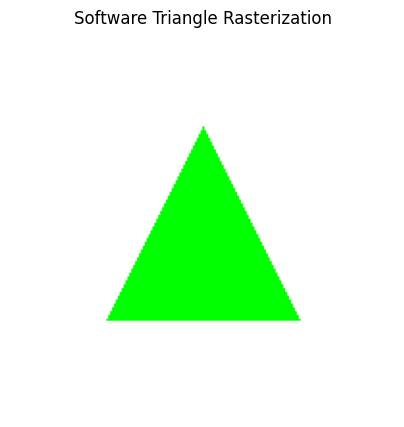

In [26]:
def display_rasterized_triangle(v1, v2, v3, color, width=200, height=200):
    """Display a triangle rasterized using our software algorithm."""
    img = rasterize_triangle(v1, v2, v3, color, width, height)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("Software Triangle Rasterization")
    plt.axis('off')
    plt.show()

# mimicking how we would usually call the triangle in the PyOpenGL definition
v1 = (-0.5, -0.5, 0)
v2 = (0.5, -0.5, 0)
v3 = (0, 0.5, 0)
triangle_color = (0, 1, 0)

display_rasterized_triangle(v1, v2, v3, triangle_color)

We notice that the pixelization phenomenon in the triangle here is very clear, which is to be expected as we are rendering it pixel by pixel according to the `barycentric_coordinates` function, within the area computed by the `bounding_box` function. 

## 5- Shading Techniques

### 5.1- Flat Shading

The flat shading algorithm works as follows:

1. **Compute Surface Normal**:
    - Use the cross product of two edges of the triangle to calculate the normal vector.
    - Normalize the normal vector to ensure it has a unit length.

2. **Lighting Calculation**:
    - Define the light direction, light color, and ambient light intensity.
    - Compute the diffuse component using the dot product of the normal vector and the light direction (Lambert's cosine law).
    - Combine the ambient and diffuse components to calculate the final lighting intensity.

3. **Apply Color**:
    - Multiply the base color of the triangle by the computed lighting intensity to determine the shaded color.

4. **Rasterize the Triangle**:
    - Convert the 3D triangle vertices to 2D screen space.
    - Compute the bounding box of the triangle in screen space.
    - For each pixel in the bounding box:
      - Calculate the barycentric coordinates to check if the pixel lies inside the triangle.
      - If the pixel is inside, assign the shaded color to the pixel.

5. **Display the Result**:
    - Render the rasterized triangle with the computed flat shading.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0944272].


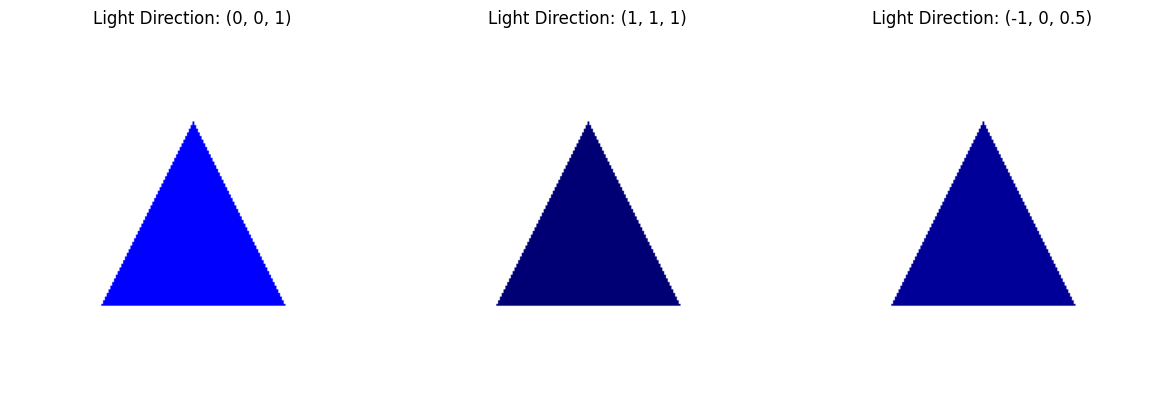

In [40]:
v1 = np.array([-0.5, -0.5, 0.0])
v2 = np.array([ 0.5, -0.5, 0.0])
v3 = np.array([ 0.0,  0.5, 0.5])
base_color = np.array([0.0, 0.0, 1.0])
light_dirs = [(0,0,1), (1,1,1), (-1,0,0.5)]

def flat_shade(v1, v2, v3, base_color, light_dir, ambient=0.2, w=200, h=200):
    n = np.cross(v2 - v1, v3 - v1)
    n = n / np.linalg.norm(n)
    l = np.array(light_dir, dtype=float)
    l = l / np.linalg.norm(l)
    intensity = ambient + max(0.0, n.dot(l))
    color = tuple((base_color * intensity).tolist())
    return rasterize_triangle(v1, v2, v3, color, w, h)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, ld in zip(axes, light_dirs):
    img = flat_shade(v1, v2, v3, base_color, np.array(ld))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Light Direction: {ld}")
plt.tight_layout()
plt.show()

### 5.1- Gouraud Shading

The Gouraud shading algorithm works as follows:

1. **Compute Surface Normal**:
    - Use the cross product of two edges of the triangle to calculate the normal vector.
    - Normalize the normal vector to ensure it has a unit length.
    - In a mesh, this would be done for each triangle face first.

2. **Build Vertex Normals**:
    - For each vertex in a mesh, compute its normal by averaging the normals of adjacent faces.
    - For our single triangle example, we'll use the same face normal for all vertices.
    - Normalize the resulting vertex normal vectors.

3. **Per-Vertex Lighting**:
    - For each vertex, compute lighting using the vertex normal and light direction.
    - Apply the ambient term plus the diffuse term (dot product of normal and light direction).
    - Calculate the shaded vertex color by multiplying the base color by the lighting intensity.

4. **Interpolate Colors**:
    - Project the triangle into screen space.
    - For each pixel inside the triangle:
      - Calculate barycentric coordinates relative to the three vertices.
      - Use these coordinates to linearly interpolate the vertex colors.
      - Assign the resulting interpolated color to the pixel.

5. **Display the Result**:
    - Render the triangle with the smoothly interpolated vertex colors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.12720003158242].


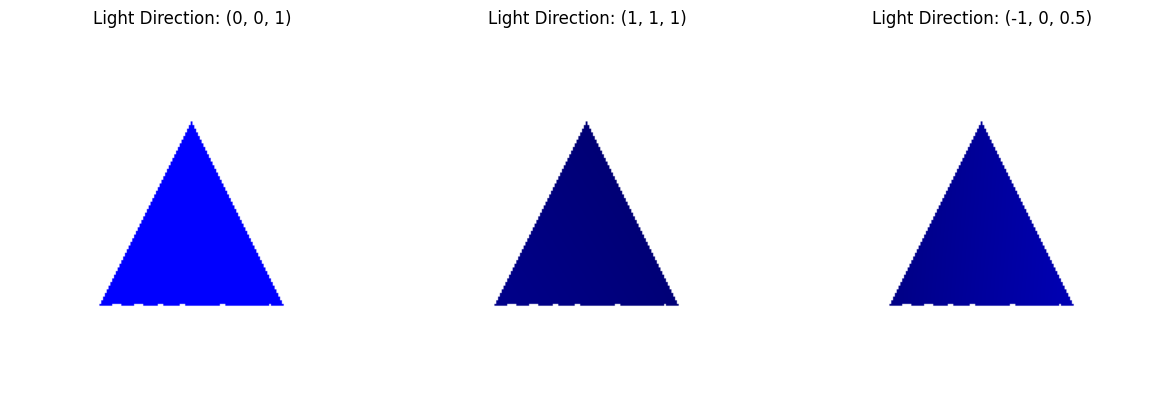

In [38]:
def gouraud_shader(v1, v2, v3, base_color, ld, ambient=0.2, w=200, h=200):
    v = np.stack([v1, v2, v3])
    fn = np.cross(v2-v1, v3-v1)
    fn /= np.linalg.norm(fn)
    perturbs = np.array([[.1,0,.1],[-.1,.1,0],[0,0,0]])
    ns = (fn + perturbs)
    ns /= np.linalg.norm(ns, axis=1)[:,None]
    Is = ambient + np.maximum(0, ns.dot(ld/np.linalg.norm(ld)))
    xs = ((v[:,0]+1)*(w-1)/2).astype(int)
    ys = ((1-v[:,1])*(h-1)/2).astype(int)
    x0,x1,x2 = xs; y0,y1,y2 = ys
    den = (y1-y2)*(x0-x2)+(x2-x1)*(y0-y2)
    img = np.ones((h, w, 3))
    for y in range(h):
        for x in range(w):
            w1 = ((y1-y2)*(x-x2)+(x2-x1)*(y-y2))/den
            w2 = ((y2-y0)*(x-x2)+(x0-x2)*(y-y2))/den
            w3 = 1-w1-w2
            if w1>=0 and w2>=0 and w3>=0:
                img[y,x] = base_color * (w1*Is[0] + w2*Is[1] + w3*Is[2])
    return img

light_dirs = [(0, 0, 1), (1, 1, 1), (-1, 0, 0.5)]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, ld in zip(axes, light_dirs):
    img = gouraud_shader(v1, v2, v3, base_color, np.array(ld))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Light Direction: {ld}")
plt.tight_layout()
plt.show()


The difference between these two basic shading algorithms is quite subtle: for `flat_shade`, it is a computationally inexpensive way to shade the triangle with just one light. Whereas `gouraud_shade` has a better and smoother color transition across the triangle's surface, producing a nice natural gradient, though this causes it to be more intensive in its computations. The usage of either then would really depend on where we want to apply them.